# Decision Tree: Motivation for Random Forest

The goal of this notebook is to **motivate the usefulness of Random Forest**. We will study Random Forest in greater detail in the next notebook.

In the current notebook we seek the answer for the following question:
- How do we improve the performance of an optimal decision tree (for a complex dataset)?

We know that although using **deep** Decision Trees we can fit complex datasets, it suffers from **high variance** (overfitting).

One technique to reduce the high variance of Decision Trees is to **train a group of Decision Trees**, each on a different random subset of the training set. 

To make predictions, we just obtain the predictions of all individual trees. Then, predict the class that gets the most votes. 

Such an ensemble of Decision Trees is called a **Random Forest**.

We will emprically investigate the superior performance of Random Forest. 

We will perform the following two tasks.
- Find the optimal Decision Tree classifier 
- Compare its performance with a Random Forest Classifier

In [1]:
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Dataset

We will use Scikit-Learn's "datasets.make_moons" function to generate a synthetic non-linear dataset that is suitable for investigating classification (as well as clustering) models. It creates two interleaving half circles.

The following parameter is used by the make_moons function:

- noise : Standard deviation of Gaussian noise added to the data.


#### We will use a larger dataset (1000 instances) and increase the noise of the data (0.4)

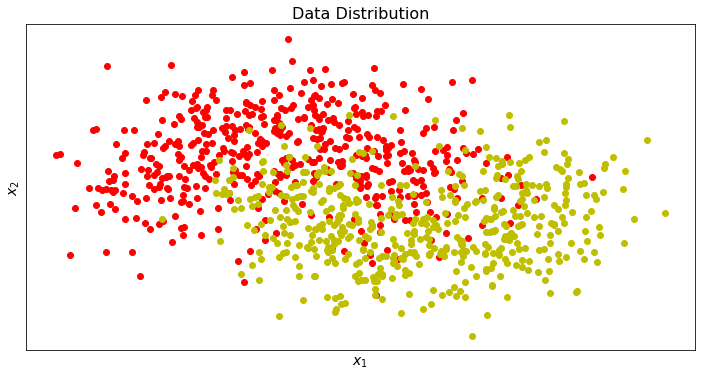

In [2]:
X, y = make_moons(1000, noise=0.4, random_state=0)

plt.figure(figsize=(12, 6))
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.title("Data Distribution", fontsize=16)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.xticks(())
plt.yticks(())
plt.show()

## Split the Dataset into Train and Test Set

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Function for Plotting Decision Bounday 


To better understand how Decision Tree classifier creates decision boundary, we need to **<font color=red size=6> visualize </font>** it.

We define the function "decision_boundary_decision_tree" to plot the decision boundary. 

In [4]:
def decision_boundary_decision_tree(clf, X, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 0.5, X[:, 0].max() + 0.5
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 0.5, X[:, 1].max() + 0.5
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.bwr, alpha=0.2)
    
    
    if(colorBar==True):
        plt.colorbar()   

## Decision Tree Model Selection: Hyperparameter Tuning

We perform model selection by finding the optimal hyperparameters via Gridsearch.

We tune the following hyperparameters that influence variance (overfitting).

- min_samples_leaf
- max_depth
- max_leaf_nodes

In [5]:
%%time

param_grid = {'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8],
              'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
              'max_leaf_nodes': [2, 5, 10, 15]}

dt_clf = DecisionTreeClassifier()

dt_clf_cv = GridSearchCV(dt_clf, param_grid, scoring='f1', cv=10)
dt_clf_cv.fit(X_train, y_train)

params_optimal = dt_clf_cv.best_params_

print("Best Score (accuracy): %f" % dt_clf_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)

Best Score (accuracy): 0.890212
Optimal Hyperparameter Values:  {'min_samples_leaf': 7, 'max_leaf_nodes': 10, 'max_depth': 3}
CPU times: user 7.45 s, sys: 30.8 ms, total: 7.48 s
Wall time: 7.49 s


## Decision Tree: Train the Optimal Classifier

In [6]:
tree_clf = DecisionTreeClassifier(**params_optimal)

tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Decision Tree: Evaluate the Optimal Classifier on Test Data

In [7]:
y_test_predicted = tree_clf.predict(X_test)

test_accuracy_tuned = accuracy_score(y_test, y_test_predicted)
print("Test Accuracy: ", test_accuracy_tuned)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Test Accuracy:  0.78

Test Confusion Matrix:
[[67 27]
 [17 89]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        94
           1       0.77      0.84      0.80       106

   micro avg       0.78      0.78      0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200



# Random Forest

We experimented with the hyperparameter values and derived near-optimal values. Ideally we should have performed a grid search for hyperparameter tuning.

In [8]:
rnd_forest_clf = RandomForestClassifier(n_estimators=1000, criterion="gini", max_features="auto", 
                                    verbose=1, max_depth=20, class_weight="balanced", oob_score=True, n_jobs=-1)


rnd_forest_clf.fit(X_train, y_train)


y_test_predicted_rf = rnd_forest_clf.predict(X_test)

test_accuracy_rf = accuracy_score(y_test, y_test_predicted_rf)
print("Test Accuracy: ", test_accuracy_rf)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted_rf))


print("\nScore of the training dataset obtained using an out-of-bag estimate: ", rnd_forest_clf.oob_score_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


Test Accuracy:  0.805

Test Confusion Matrix:
[[74 20]
 [19 87]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79        94
           1       0.81      0.82      0.82       106

   micro avg       0.81      0.81      0.81       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.81      0.80       200


Score of the training dataset obtained using an out-of-bag estimate:  0.86125


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


## Comparing The Performance of Two Classifiers

We see that the optimal Decision Tree has larger variance (low test accuracy) as compared to the Random Forest classfier. 

- Decision Tree: Test Accuracy = 0.78 
- Random Forest: Test Accuracy = 0.805

Thus, Random Forest classifier reduces the variance of Decision Trees and increases classifier accuracy.

Below we show the decision boundaries of these two classifiers.

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished


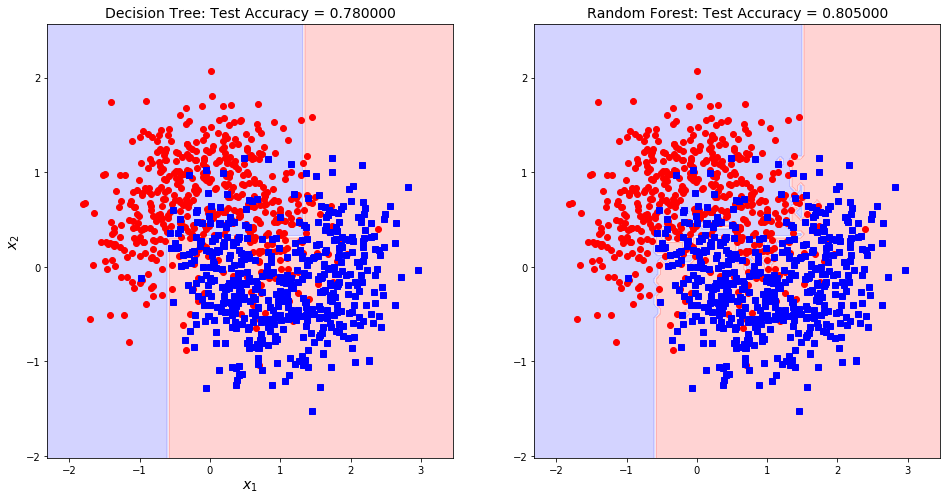

In [10]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
decision_boundary_decision_tree(tree_clf, X)

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.title("Decision Tree: Test Accuracy = %f" 
          % (test_accuracy_tuned), fontsize=14)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)

plt.subplot(122)
decision_boundary_decision_tree(rnd_forest_clf, X)

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.title("Random Forest: Test Accuracy = %f" 
          % (test_accuracy_rf), fontsize=14)

plt.show()